# **Working memory training**: Whole-brain module allegiance analysis

Karolina Finc | Centre for Modern Interdisciplinary Technologies, Nicolaus Copernicus University in Toruń, Poland

**Last edited:** 04-10-2018

Step 0: Loading libraries
--------------------------------------------

In [2]:
import sys
sys.path.append("..")
import os

%matplotlib inline

import scipy.io as sio
import numpy as np
from nilearn import plotting 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from fctools import networks, figures

#---- matplotlib settings
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
plt.rcParams['font.family'] = 'Helvetica'

Step 1: Selecting subjects to analysis
--------------------------------------------

In [22]:
# Selecting subjects which finished the study
groups = pd.read_csv('../data/behavioral/group_assignment.csv')

trained = (groups.group == 'Experimental') | (groups.group == 'Control')
trained_subs = groups[trained]
subs = trained_subs['sub'].values

#--- creating vectors to filter by group
experimental = (trained_subs == 'Experimental')
control = (trained_subs == 'Control')

exp_vector = experimental['group'].values
con_vector = control['group'].values

#--- dualnback - selecting subjects included into dinal analysis and creating group assignment vectors
dualnback_exclude = ['sub-13', 'sub-21', 'sub-23', 'sub-50'] # higly motion subjects in one of four sessions
dual_vector = [True if sub not in dualnback_exclude else False for sub in subs]
exp_vector = exp_vector[dual_vector]
con_vector = con_vector[dual_vector]
subs = trained_subs['sub'][dual_vector].values

n = sum(dual_vector)
print(f'Number of subject after excluding subjects with higly motion: {n}')

Number of subject after excluding subjects with higly motion: 42


Step 2: Getting modules names and color pallete
----------------------------------------

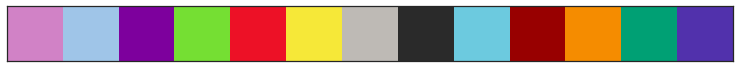

In [8]:
top_dir = '/home/finc/Dropbox/Projects/LearningBrain/'
labels = pd.read_csv('../support/modules.txt', sep = " ", header = None)

power_colors_new = {'AU':'#d182c6', 
                'CER':'#9fc5e8', 
                'CO':'#7d009d', 
                'DA':'#75df33', 
                'DM':'#ed1126', 
                'FP':'#f6e838', 
                'MEM':'#bebab5', 
                'SAL':'#2a2a2a', 
                'SOM':'#6ccadf', 
                'SUB':'#980000', 
                'UNC':'#f58c00', 
                'VA':'#00a074', 
                'VIS':'#5131ac',}

modules = sorted(labels[0].values)
network_pal = (sns.color_palette(power_colors_new.values()))
sns.palplot(sns.color_palette(power_colors_new.values()))

network_lut = dict(zip(map(str, np.unique(modules)), network_pal))

network_colors = pd.Series(modules).map(network_lut)
network_colors = np.asarray(network_colors)

n_roi = len(labels)
n_net = len(np.unique(modules))

Step 2: Loading allegiance matrices
-------------------------------------------------------------------------------

In [9]:
P = np.load(f'{top_dir}data/neuroimaging/03-modularity/dynamic/03-allegiance_matrices/allegiance_matrix_power_dualnback_opt_mean.npy')
P = P[dual_vector, :, : ,:]
P.shape

(42, 4, 264, 264)

Step 3: Plotting allegiance matrices (all nodes)
---------------------------------

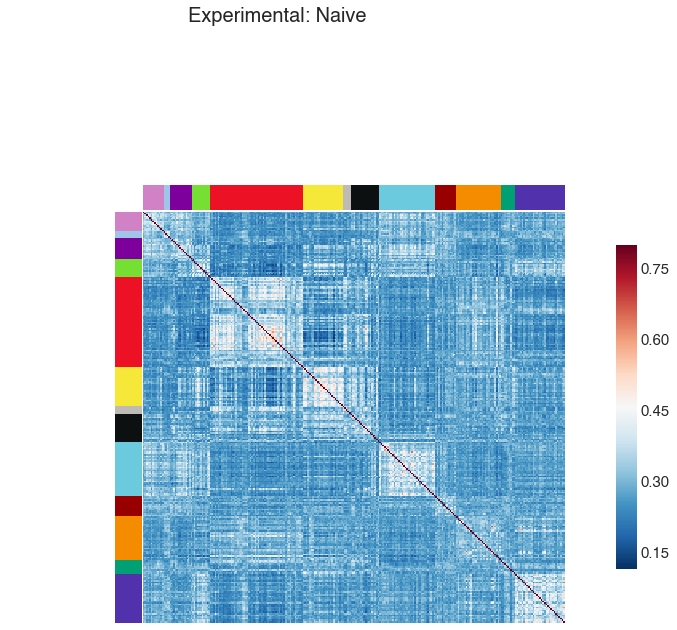

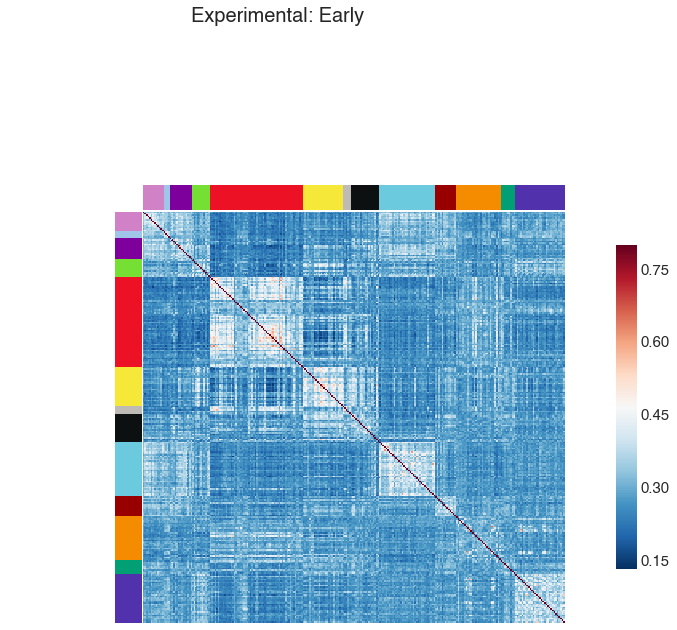

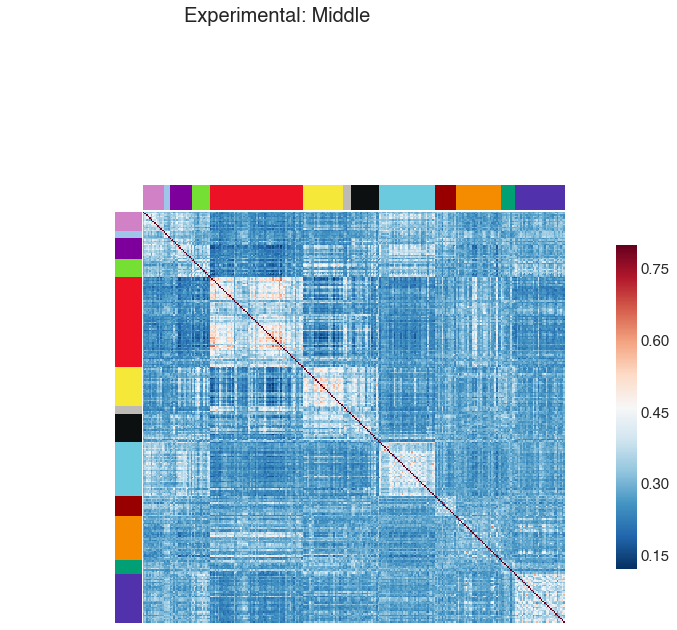

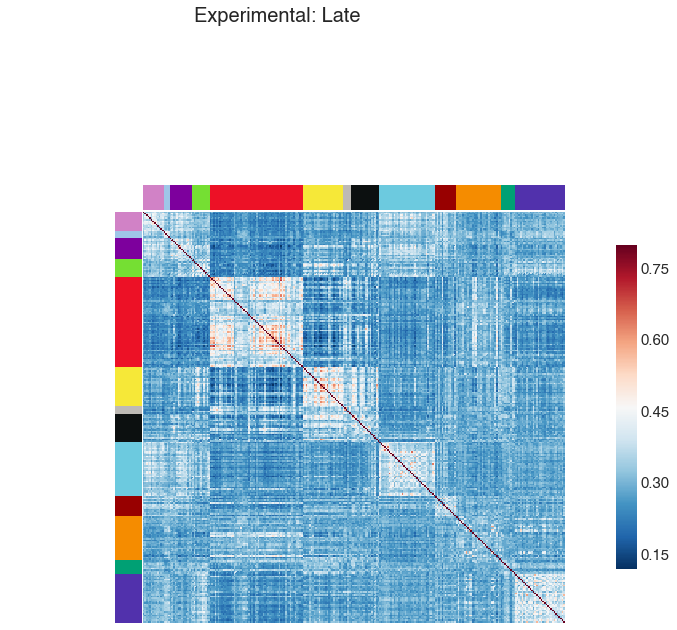

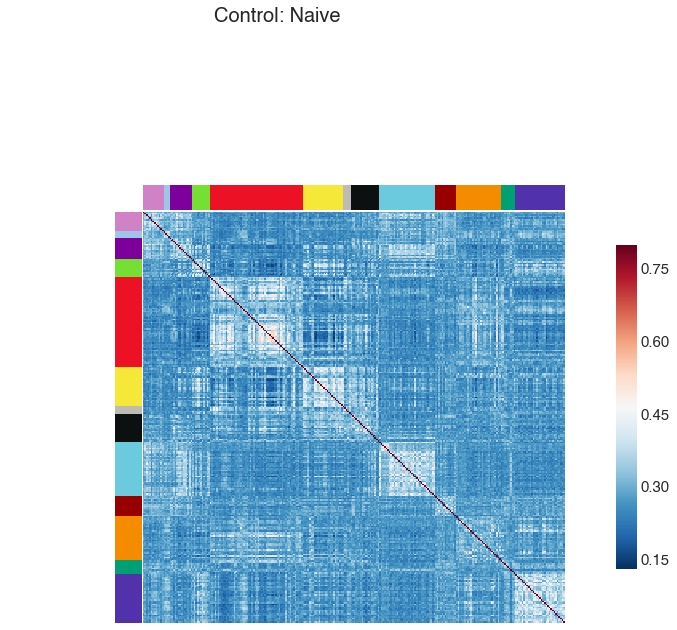

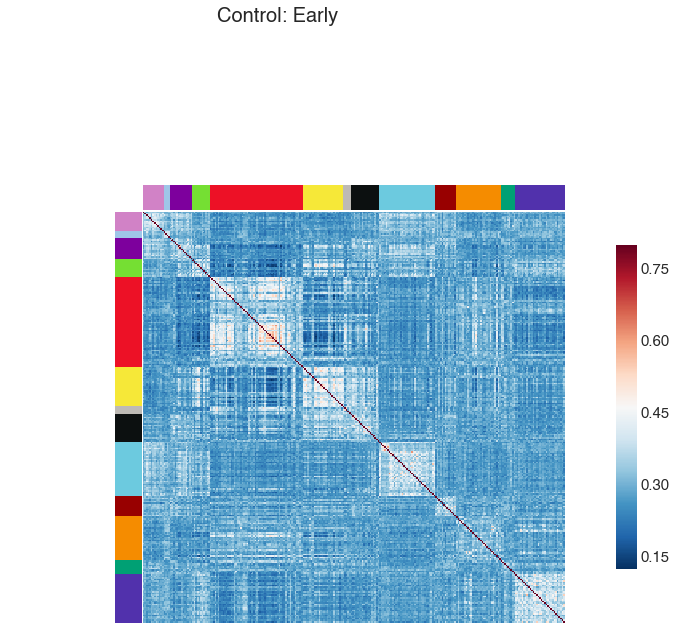

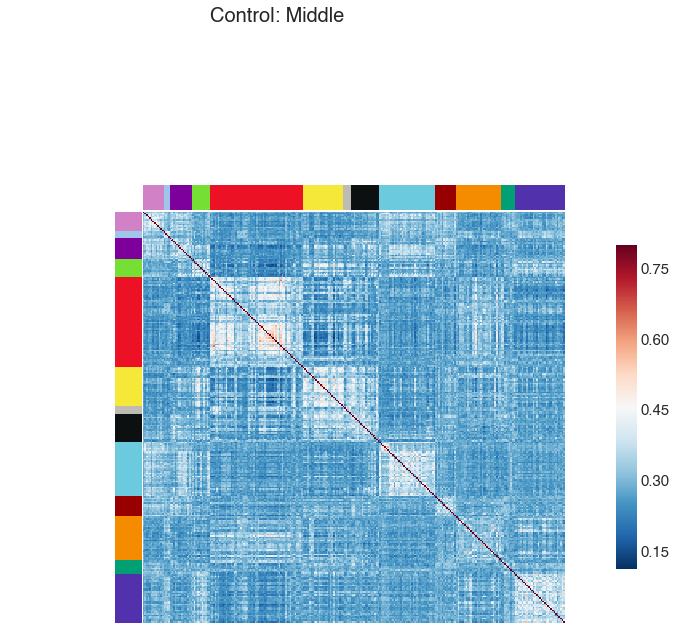

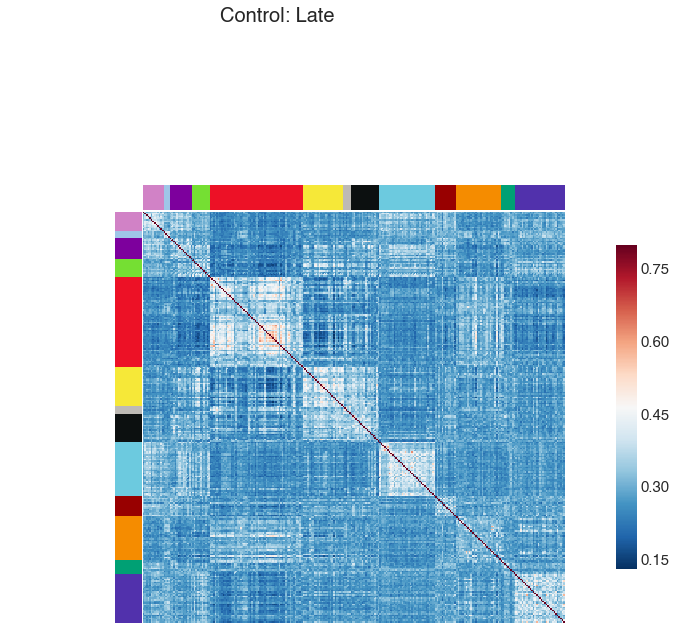

In [8]:
group_vectors = [exp_vector, con_vector]
ses_lab = ['Naive', 'Early', 'Middle', 'Late']
group_lab = ['Experimental', 'Control']

#--- generating matrix plots with colors for each network
for i, vec in enumerate(group_vectors):
    for j, ses in enumerate(ses_lab):
        M = P[vec, j, :, :].mean(axis = 0)
        ax = figures.matrix_networks_plot(M, network_colors, dpi = 100, colorbar = True, group = group_lab[i], ses = ses, suffix = None, out_dir = None)



Step 4: Node allegiances t-tests
-----------------------------

In [176]:
# Calculating t-tests betwen ij-element of node allegiance P matrix 
# between Naive and Late scanning session

n_nod = 264
ttest_allegiances = np.zeros((2, n_nod, n_nod))

for g, vec in enumerate(group_vectors):
    for i in range(n_nod):
        for j in range(n_nod):
            stat, pval =  stats.ttest_rel(P[vec,3,i,j], P[vec,0,i,j])
            ttest_allegiances[g,i,j] = stat

group_vectors = [exp_vector, con_vector]
group_lab = ['Experimental', 'Control']


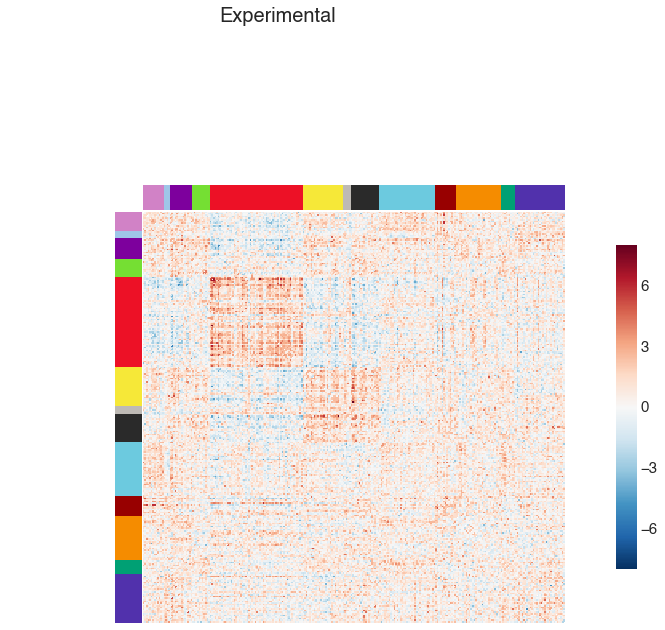

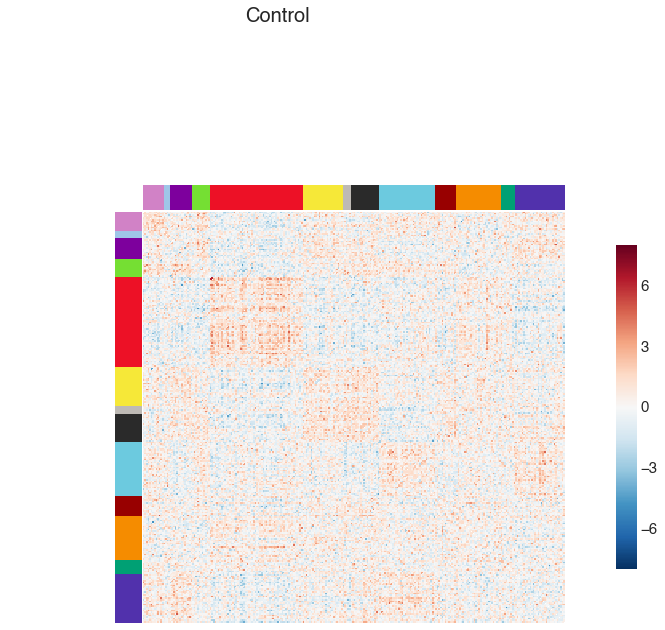

In [177]:
for i, vec in enumerate(group_lab):
    plot = figures.matrix_networks_slope_plot(ttest_allegiances[i, :, :],
                                              network_colors,
                                              dpi = 100, 
                                              colorbar = True, 
                                              group = group_lab[i], 
                                              suffix = None, 
                                              vmin = -8, 
                                              vmax = 8)

Step 5: Making grid plot with mean allegiances between/within systems
----------------------------------------------------------------

In [11]:
# Calculate recruitment/integration grouped by distnct networks
NA = networks.fc_cartography_4d(P, modules)
NA.shape

(42, 4, 13, 13)

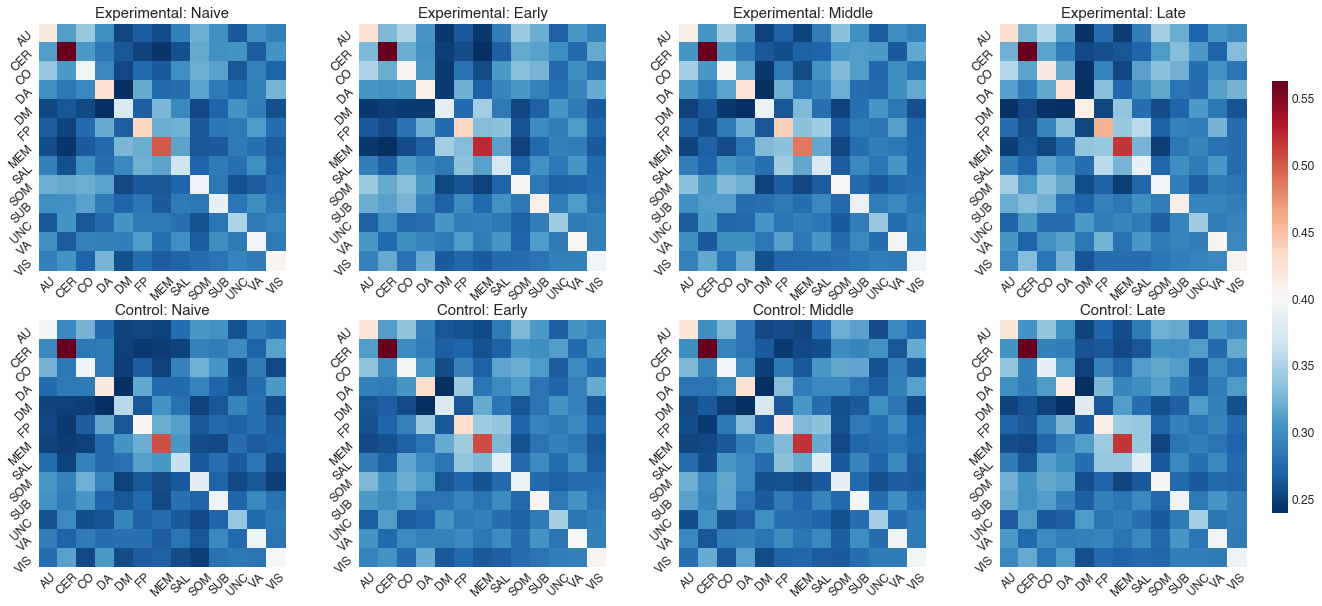

In [13]:
#--- plotting mean allegiances grouped by distinct networks
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)  
plt.rc('axes', linewidth=0)

fig, axes = plt.subplots(2, 4)
fig.set_size_inches(22, 10)
group_vectors = [exp_vector, con_vector]
ses_lab = ['Naive', 'Early', 'Middle', 'Late']
group_lab = ['Experimental', 'Control']

for i, vec in enumerate(group_vectors):
    for j, ses in enumerate(ses_lab):
        M = NA[vec,j, :,:].mean(axis=0)
        plt.ioff()
        g = sns.heatmap(M, yticklabels = np.unique(modules), 
                        xticklabels = np.unique(modules), 
                        square = True, 
                        cmap = "RdBu_r", 
                        ax=axes[i][j],
                        #vmin = 0.25, vmax = 0.45,
                        cbar=None)
        g.set_title(f'{group_lab[i]}: {ses}', size = 15)
        g.set_xticklabels(np.unique(modules), rotation=45)
        g.set_yticklabels(np.unique(modules), rotation=45)

im = plt.gca().get_children()[0]
cax = fig.add_axes([.91, .2, .01, .6]) 
fig.colorbar(im, cax=cax, drawedges = False)


Step 6: Calculate ttests for mean recruitment and integration values
----------------------------------

In [14]:
group_vectors = [exp_vector, con_vector]
group_lab = ['Experimental', 'Control']
mm_stat = np.zeros((2,13,13))
mm_pval = np.zeros((2,13,13))

for v, vec in enumerate(group_vectors):
    for i in range(13):
        for j in range(13):
            stat, pval = stats.ttest_rel(NA[vec, 3, i, j], NA[vec, 0, i, j])
            mm_stat[v,i,j] = stat 
            mm_pval[v,i,j] = round(pval, 4)

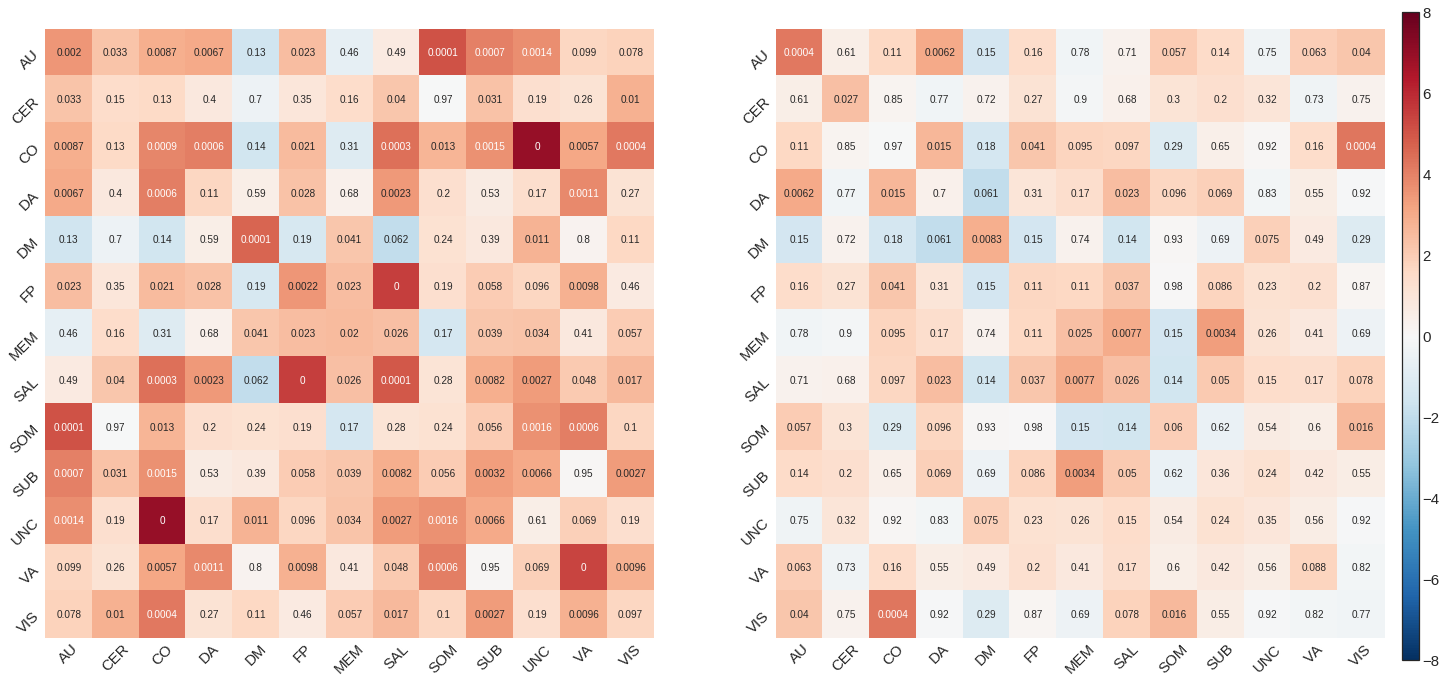

In [16]:
plt.rc('font', size=10)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=15) 
plt.rc('axes', linewidth=0)


plt.style.use('seaborn-white')
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(22, 10)
group_vectors = [exp_vector, con_vector]
group_lab = ['Experimental', 'Control']

for i, vec in enumerate(group_vectors):
        fig = plt.gcf()
        fig.set_size_inches(24, 15)

        plt.ioff()
        g = sns.heatmap(mm_stat[i, :, :], 
                        yticklabels = np.unique(modules), 
                        xticklabels = np.unique(modules), 
                        square = True, 
                        cmap = "RdBu_r", 
                        ax=axes[i],
                        vmin = -8, vmax = 8,
                        cbar=None,#,
                        annot = mm_pval[i, :, :])
        #g.set_title(f'{group_lab[i]}: {ses}', size = 15)
        g.set_xticklabels(np.unique(modules), rotation=45)
        g.set_yticklabels(np.unique(modules), rotation=45)

im = plt.gca().get_children()[0]
cax = fig.add_axes([.91, .2, .01, .6]) 
fig.colorbar(im, cax=cax, drawedges = False)

Step 7:Generating pandas data.frame with recruitment and integration values
-----------------------------------------------------------------------

In [23]:
# Recruitment values
df_recr = pd.DataFrame()
for g, group in enumerate(group_lab):
    for n, net in enumerate(np.unique(modules)):
        x = mm_stat[g, n, n]
        y = mm_pval[g, n, n]
        result_pre = pd.DataFrame({'Group': group,
                                   'Network': net,
                                   'Recruitment_ttest': x,
                                  'Recruitment_pval': y},index = [0])               
        df_recr = df_recr.append(result_pre)         
        

In [24]:
# Integration values
df_integ = pd.DataFrame()
for g, group in enumerate(group_lab):
    for n1, net1 in enumerate(np.unique(modules)):
        for n2 in range(n1):
            if n1 == n2:
                continue
            else:
                x = mm_stat[g, n1, n2]
                y = mm_pval[g, n1, n2]
                result_pre = pd.DataFrame({'Group': group,
                                   'Network': f'{net1}-{np.unique(modules)[n2]}',
                                   'Integration_ttest': x,
                                   'Integration_pval': y},index = [0])  
                df_integ = df_integ.append(result_pre) 

Step 8: Plotting rectruitment results
----------------------------------

In [25]:
df_exp = df_recr[df_recr.Group == 'Experimental']
result = df_exp.sort_values('Recruitment_ttest', ascending = False)


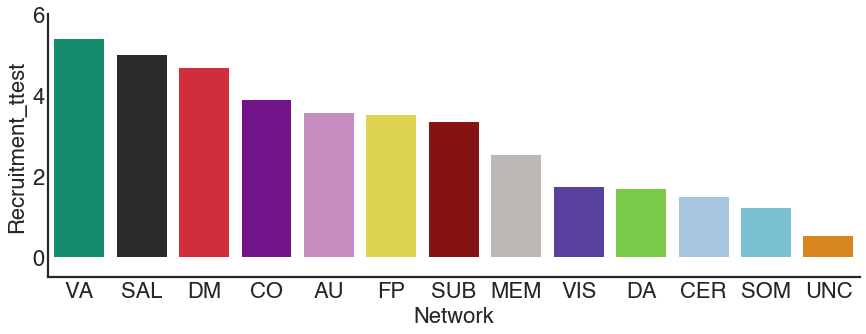

In [27]:
plt.style.use('seaborn-white')
plt.rcParams['font.family'] = 'Helvetica'

small = 22
medium = 22
bigger = 22

plt.rc('font', size=small)          # controls default text sizes
plt.rc('axes', titlesize=small)     # fontsize of the axes title
plt.rc('axes', linewidth=2.2)
plt.rc('axes', labelsize=medium)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=small)    # fontsize of the tick labels
plt.rc('ytick', labelsize=small)    # fontsize of the tick labels
plt.rc('legend', fontsize=small)    # legend fontsize
plt.rc('figure', titlesize=bigger)  # fontsize of the figure title
plt.rc('lines', linewidth=2.2, color='gray')

df_exp = df_recr[df_recr.Group == 'Experimental']
result_exp = df_exp.sort_values('Recruitment_ttest', ascending = False)

sns.catplot(y = 'Recruitment_ttest', x = 'Network', data = df_exp, kind = 'bar', aspect = 2.5, order = result_exp['Network'], palette = power_colors_new)
plt.ylim(-0.5, 6)
plt.savefig(f'{top_dir}figures/fig_12exp.pdf', bbox_inches="tight", dpi=300)

In [239]:
result_exp

,Group,Network,Recruitment_ttest,Recruitment_pval
0,Experimental,VA,5.396019,0.0000
0,Experimental,SAL,4.996771,0.0001
0,Experimental,DM,4.669766,0.0001
0,Experimental,CO,3.881891,0.0009
0,Experimental,AU,3.561145,0.0020
0,Experimental,FP,3.515675,0.0022
0,Experimental,SUB,3.349515,0.0032
0,Experimental,MEM,2.525482,0.0201
0,Experimental,VIS,1.738904,0.0974
0,Experimental,DA,1.689421,0.1067


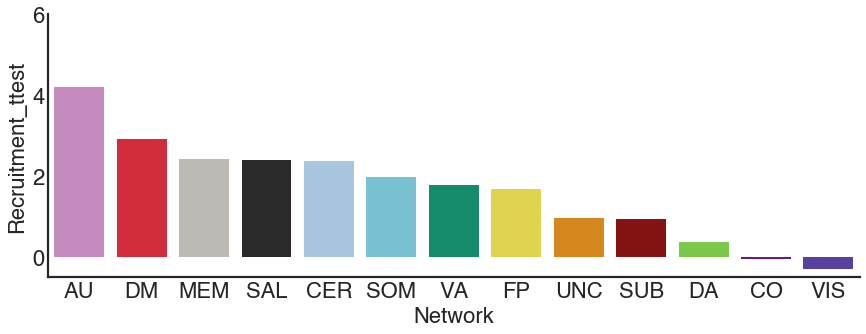

In [240]:
df_con = df_recr[df_recr.Group == 'Control']
result_con = df_con.sort_values('Recruitment_ttest', ascending = False)

sns.catplot(y = 'Recruitment_ttest', x = 'Network', data = df_con, kind = 'bar', aspect = 2.5, order = result_con['Network'], palette = power_colors_new)
plt.ylim(-0.5, 6)
plt.savefig(f'{top_dir}figures/fig_12con.pdf', bbox_inches="tight", dpi=300)

In [242]:
result_con

,Group,Network,Recruitment_ttest,Recruitment_pval
0,Control,AU,4.197003,0.0004
0,Control,DM,2.926896,0.0083
0,Control,MEM,2.413845,0.0255
0,Control,SAL,2.403658,0.0260
0,Control,CER,2.386749,0.0270
0,Control,SOM,1.990775,0.0603
0,Control,VA,1.790446,0.0885
0,Control,FP,1.688726,0.1068
0,Control,UNC,0.958067,0.3495
0,Control,SUB,0.946477,0.3552


Step 9: Plotting integration results
----------------------------------

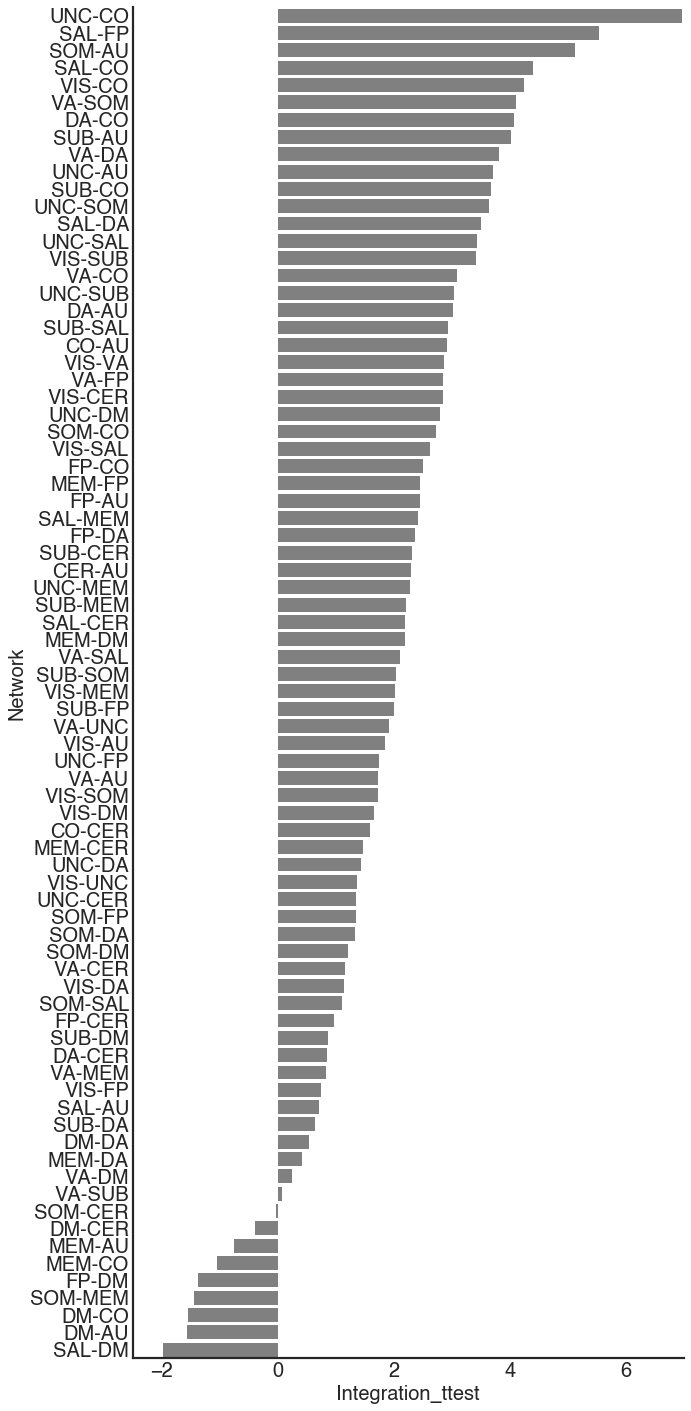

In [233]:
df_exp_integ = df_integ[df_integ.Group == 'Experimental']
result_int_exp = df_exp_integ.sort_values('Integration_ttest', ascending = False)

sns.catplot(x = 'Integration_ttest', y = 'Network', data = df_exp_integ, height = 20, aspect = 0.5, kind = 'bar', order = result_int_exp['Network'], orient='h', color = 'grey')
plt.xlim(-2.5, 7)
plt.savefig(f'{top_dir}figures/fig_13exp.pdf', bbox_inches="tight", dpi=300)

In [243]:
result_int_exp

,Group,Network,Integration_ttest,Integration_pval
0,Experimental,UNC-CO,6.966515,0.0000
0,Experimental,SAL-FP,5.531550,0.0000
0,Experimental,SOM-AU,5.123538,0.0001
0,Experimental,SAL-CO,4.399429,0.0003
0,Experimental,VIS-CO,4.235676,0.0004
0,Experimental,VA-SOM,4.103889,0.0006
0,Experimental,DA-CO,4.068420,0.0006
0,Experimental,SUB-AU,4.013271,0.0007
0,Experimental,VA-DA,3.814314,0.0011
0,Experimental,UNC-AU,3.714251,0.0014


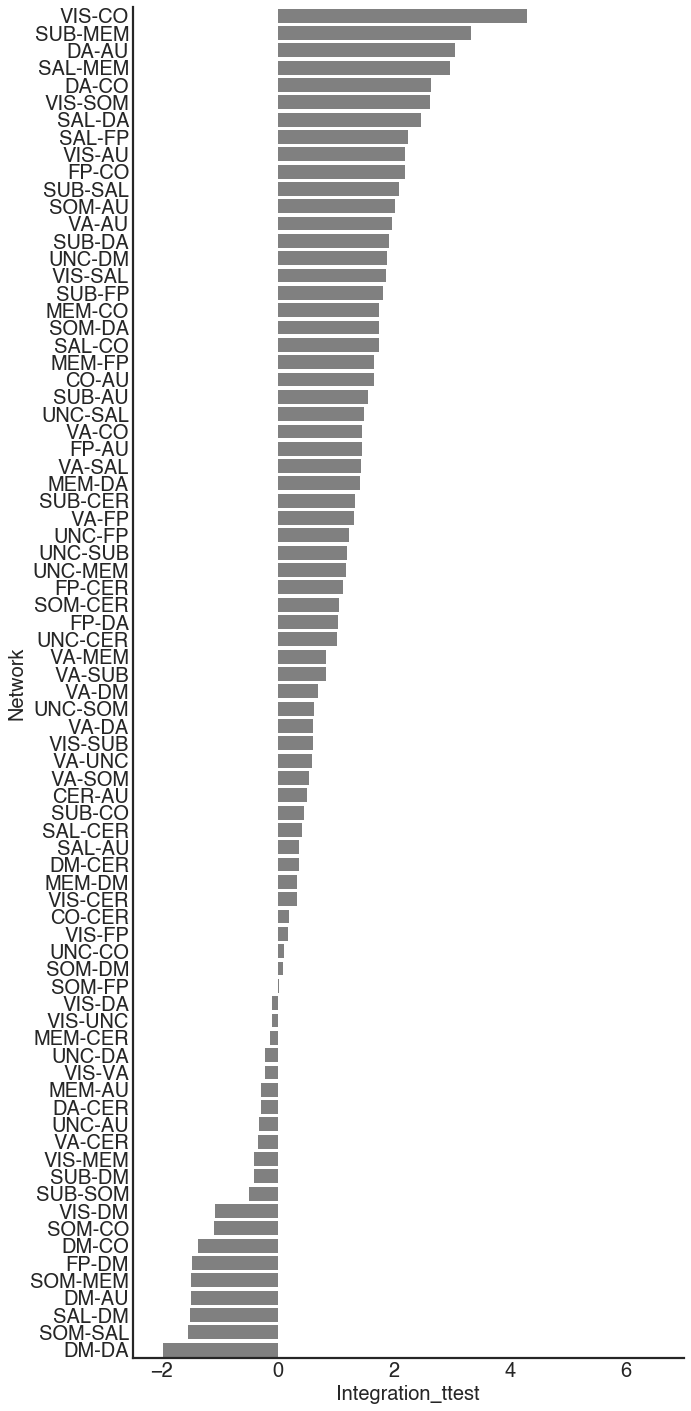

In [230]:
df_con_integ = df_integ[df_integ.Group == 'Control']
result = df_con_integ.sort_values('Integration_ttest', ascending = False)

sns.catplot(x = 'Integration_ttest', y = 'Network', data = df_con_integ, height = 20, aspect = 0.5, kind = 'bar', order = result['Network'], orient='h', color = 'grey')
plt.xlim(-2.5, 7)
plt.savefig(f'{top_dir}figures/fig_13con.pdf', bbox_inches="tight", dpi=300)

Step 10: Calculate slope of changes or allegiances within/between network
--------------------------------------------------------------------

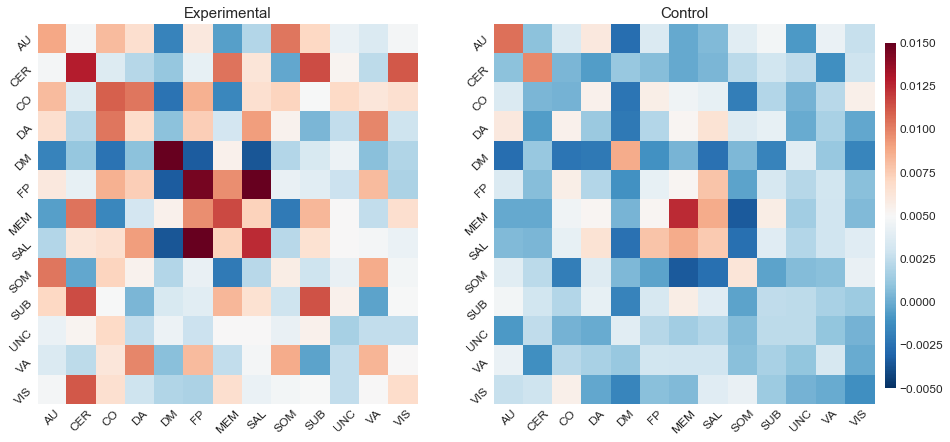

In [79]:
n = 42

#--- calculate slopes
xi = np.arange(1,5)
slopes = np.zeros((n,n_net,n_net))


for sub in range(n):
    for i in range(n_net):
        for j in range(n_net):
            vec = NA[sub,:,i,j]
            slope, intercept, r_value, p_value, std_err = stats.linregress(xi,vec)
            slopes[sub,i,j] = slope

#--- plotting mean allegiances grouped by distinct networks
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)  
plt.rc('axes', linewidth=0)

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15, 8)
group_vectors = [exp_vector, con_vector]
group_lab = ['Experimental', 'Control']

for i, vec in enumerate(group_vectors):
        mean_slope = slopes[vec, :,:].mean(axis = 0)
        plt.ioff()
        g = sns.heatmap(mean_slope, yticklabels = np.unique(modules), 
                        xticklabels = np.unique(modules), 
                        square = True, 
                        cmap = "RdBu_r", 
                        ax=axes[i],
                        vmin = -0.005, vmax = 0.015,
                        cbar=None)
        g.set_title(f'{group_lab[i]}', size = 15)
        g.set_xticklabels(np.unique(modules), rotation=45)
        g.set_yticklabels(np.unique(modules), rotation=45)

im = plt.gca().get_children()[0]
cax = fig.add_axes([.91, .2, .01, .6]) 
fig.colorbar(im, cax=cax, drawedges = False)